# GLLVM for longitudinal data: a pytorch implementation

We consider the following model

TODO:
* learn the nuisance parameters! To learn phi, make the encoder learn the zhats **before** AR(1) is applied, and take the gradient of the decoder. that is, make the decoder have phi as a parameter, and same for var_mu!
* allow for gaussian and binary data
* Compute the gradient that define the model
* allow for missing values and impute them


 ## Model Specification

Let  $y_{i1t},y_{i2t},\ldots,y_{ipt}$  be a set of $p$ response or observed variables at time $t,\ t=1,\ldots,T$ for  individual $i,\ i=1,\ldots,n$. Let $\mathbf{x}_{it}$ be a set of observed $k$-dimensional covariates at time $t,\ t=1,\ldots,T$.

Models for multivariate longitudinal data have to account for the three sources of variability
present in the data, that is (i) cross-sectional associations between the responses at a particular time point, (ii) cross-lagged
associations between different responses at different occasions, and  (iii) the association between repeated measures of the same response
over time. The first source of variability is accounted for
a time-dependent latent variable $z_{i1}, z_{i2},\ldots,z_{iT}$. Modeling the temporal evolution of the latent variable accounts for the cross-lagged associations between different responses over time.
The third source of variability can be accounted for a set of item-specific random effects $\mathbf{u}_{i}=(u_{i1}, \ldots, u_{ip})'$.

According to the GLLVM framework we have

\begin{align*}
   \nonumber y_{ijt}|\mu_{ijt} &\sim \mathcal{F}_j(y_{ijt}\vert \mu_{ijt}, \tau_j)\\
   \mu_{ijt}&=  g_j(\eta_{ijt})=g_j(\beta_{0jt} + \mathbf{x}_{i}^{\top}\boldsymbol \beta_{jt} + z_{it}^{\top}\lambda_{jt}+u_{ij}\sigma_{u_j})\\ %  \label{eqn:GLLVM-model2}
\end{align*}
where $g_j(\cdot),j=1,\ldots,p$ is a known {\it link function}, $\eta_{ijt}=\beta_{0jt} + \mathbf{x}_{i}^{\top}\boldsymbol \beta_{jt} + z_{it}^{\top}\lambda_{jt}+u_{ij},i=1,\ldots,n,j=1,\ldots,p, t=1,\ldots,T$ is the {\it linear predictor},  and $\mathcal{F}_j(y_{ijt}\vert \eta_{ijt}, \tau_j)$ denotes a distribution from the exponential family with mean $\mu_{ijt}$ and response variable-specific dispersion parameter $\tau_j$. \vspace{5pt}\\
The dynamics of the latent variable over time is modelled through a non-stationary autoregressive model of first order

\begin{equation*}
z_{it}=\phi z_{i,t-1} + \delta_{it}
\end{equation*}%
where  $z_{i1}\sim N(0,\sigma^2_{1})$ and $\delta_{it}\sim N(0,1)$.  Moreover, we assume the random effects independent of the latent variable and their common distribution $\mathbf{u}_{i}\sim N_p(\mathbf{0}, \boldsymbol I)$.


### Changes I propose:

allow x to depend on time.


## Measurement invariance

The  latent variable $z_{it}$ has to be the same (same meaning) across occasions.
Thus the measurement invariance assumption has to be tested on the data, that is 
all the measurement parameters  are invariant across occasions, that is $$\beta_{0jt}=\beta_{0j} \ \textrm{and } \ \lambda_{jt}=
\lambda_{j},$$ for all $t$, $t=1, \ldots, T$ and for all $j$, $j=1,\ldots, p$.
Under this assumption, the model is more parsimonious  and avoids some possible identification problem that might arise with
increasing the number of time points.

To ensure identification of the model, one necessary condition is that the latent variable has a scale and an origin. %When measurement
%invariance of loadings and intercepts is imposed,
Scale for  $z_{it}$  can be provided either by fixing one loading at a nonzero value or by
fixing the factor variance at a nonzero value. In presence of longitudinal data, the same loading is fixed equal to one at each occasion.


## Fast prototyping using Pytorch

We model each observation as a tuple of dimension `(T, p)`, common across individuals. Individuals constitute independent observations, which yields the tensor structure `(n, T, q)`. The time dimension `T` appears in the first dimension since it allows for seamless tensor products of the type `(n, T, q) (q, p)`.

We need

* A model that defines the generative process
* A loss function which, upon taking the derivative, re-creates the estimating equations
* A way to compute the latent variables. For now, we will use a neural network. Later, we can implement the real function.


In [55]:
import torch
from torch import nn
import numpy as np
import math
import matplotlib.pyplot as plt
import copy

n = 1000
p = 200
T = 20
k = 3
q = 1

DIMENSIONS_Y = (n, T, p) 
DIMENSIONS_X = (n, T, k)
DIMENSIONS_Z = (n, T, q)
DIMENSIONS_U = (n, 1, p)

# TODO: refactor to have a module of two modules: encoder and decoder
class GLLVM_longitudinal():
    def __init__(self):
        self.encoder = Encoder()
        self.decoder = Decoder()

    def encoder_fit(self, x, y, d, u, epochs=100, verbose=False):
        encoder_loss = nn.MSELoss()
        encoder_opt = torch.optim.Adam(self.encoder.parameters())
        for epoch in range(epochs):
            (dhat, uhat) = self.encoder(x, y)
            loss = encoder_loss(dhat, d) + encoder_loss(uhat, u)
            if verbose:
                print(f"\nEpoch {epoch}/{epochs}, loss={loss}")
            loss.backward()
            encoder_opt.step()
            encoder_opt.zero_grad()
        return loss
    
    def sample(self, n, x=None, u=None, d=None):
        with torch.no_grad():
            """Sample a longitudinal GLLVM, potentially with z, u, and d(elta), and return (x, z, u, d, y)"""

            if x is None:
                Warning("x was set to None for sampling. This is usually unwanted unless k=0.")
                x = torch.randn((n, T, k))
            if u is None:
                u = torch.randn((n, 1, p))
            if d is None:
                d = torch.randn((n, T, q))

            eps = torch.randn((n, T, p)) * torch.sqrt(self.decoder.var_y)
            y = self.decoder(x, d, u) + eps

            return {"x":x, "u":u, "d":d, "y":y}

class Decoder(nn.Module):
    def __init__(self):
        super().__init__()

        # decoder part (our parameters of interest)
        self.wz = nn.Parameter(torch.randn((q, p)))
        self.wx = nn.Parameter(torch.randn((T, k, p)))
        self.bias = nn.Parameter(torch.zeros((1, T, p)))
        self.phi = nn.Parameter(torch.ones(1) * .8)

        # nuisance parameters
        self.var_u = nn.Parameter(torch.ones((1,1,p)))
        self.var_y = nn.Parameter(torch.ones((1,1,p))) # this appears in the loss function

    # decoding
    def forward(self, x, d, u):
        z = self.AR(d)
        u = u * torch.sqrt(self.var_u)
        xwx = (x.unsqueeze(2) @ self.wx).squeeze() # see section "details of tensorproducts"
        zwz = (z.unsqueeze(2) @ self.wz).squeeze()
        linpar = self.bias + xwx + zwz + u 
        return linpar

    def AR(self, d):
        z = d.clone()

        for t in range(1, z.shape[1]):
            z[:,t] = z[:,t] + z[:, t-1].clone() * self.phi  # we need to clone else the gradient wants to pass through it
        return z

class Encoder(nn.Module):
    def __init__(self):
        super().__init__()
        # encoder part
        # input dimension is T * (p+k)... we buuild a fully connected layer but it isn't necessary 
        # output dimension is T*q  + p (for Z and U, respectively)
        self.enc_model = nn.Sequential(
            nn.Linear(in_features=T*(p+k), out_features = 100),
            nn.ReLU(),
            nn.Linear(in_features=100, out_features = 100),
            nn.ReLU(),
            nn.Linear(in_features=100, out_features = 100),
            nn.ReLU(),
            nn.Linear(in_features=100, out_features = T*q + p)
        )
    
    def forward(self, x, y):
        xy = torch.cat([x, y], dim=2).flatten(start_dim=1)
        zu = self.enc_model(xy)
        return self.split_zu(zu)

    def split_zu(self, du):
        #output dimension of size (T*Z), p
        d, u = torch.split(du, [T*q, p], dim=1)
        d = d.reshape((d.shape[0], T, q))
        u = u.unsqueeze(1)
        return (d, u)



In [56]:
gl_true = GLLVM_longitudinal()
dat_true = gl_true.sample(n)


gl = GLLVM_longitudinal()

with torch.no_grad():
    gl.decoder.phi *= .8
    gl.decoder.var_y *= 1.1
    gl.decoder.var_u *=.8

gl = copy.deepcopy(gl_true) #making it start with the same parameter values

In [57]:
def my_loss(input, target, var_y, sign=1):
    #return sign * torch.sum(input*target / torch.sqrt(var_y), dim=[1,2]).mean()
    return sign * torch.mean(input*target / torch.sqrt(var_y)) + torch.log(var_y).mean()

def evaluate_fit(input, target):
    with torch.no_grad():
        return torch.sum(torch.pow(input - target,2), dim=[1,2]).mean()

In [58]:
dat_sim = gl.sample(n, x=dat_true["x"]) # x are known and fixed

# train the encoder

gl.encoder_fit(dat_sim["x"], dat_sim["y"], dat_sim["d"], dat_sim["u"], epochs=100)

tensor(0.8147, grad_fn=<AddBackward0>)

In [59]:
epochs = 1000
lr_init = 1
for epoch in range(1, epochs+1):
    lr= lr_init/math.sqrt(epoch)
    
    dat_sim = gl.sample(n, x=dat_true["x"]) # x are known and fixed 

    # train the encoder
    encoder_loss = gl.encoder_fit(dat_sim["x"], dat_sim["y"], dat_sim["d"], dat_sim["u"], epochs=1 + int(50/math.sqrt(epoch)))
    # compute SPRIME sample step

    # compute imputing values
    with torch.no_grad():
        dhat_true, uhat_true = gl.encoder(dat_true["x"], dat_true["y"])

    linpar_sample = gl.decoder(dat_true["x"], dhat_true, uhat_true)
    loss = my_loss(linpar_sample, dat_true["y"], gl.decoder.var_y, sign=-1) #notice the -sign here
    loss.backward()

    # compute SPRIME simulation step
    # compute imputing values
    with torch.no_grad():
        dhat_sim, uhat_sim = gl.encoder(dat_sim["x"], dat_sim["y"])
        
    linpar_sim = gl.decoder(dat_sim["x"], dhat_sim, uhat_sim)
    loss = my_loss(linpar_sim, dat_sim["y"], gl.decoder.var_y, sign=1) # tries to pass a second time through dat_sim
    loss.backward()

    with torch.no_grad():
        for name, par in gl.decoder.named_parameters():
            if name in ["phi", "var_u", "var_y"] :
                # BETTER TO LEARN THEM! BUT HEH
                par.grad[par.grad > 1e-1] = 1e-1
                par.grad[par.grad < -1e-1] = -1e-1
                par -= par.grad * min(lr, 1)
            else :
                par -= par.grad * lr
        gl.decoder.zero_grad()
    
    # project the parameters back

    with torch.no_grad():
        gl.decoder.var_y[gl.decoder.var_y < 1e-1] = 1e-1
        gl.decoder.var_u[gl.decoder.var_y < 1e-1] = 1e-1


    # evaluate the model
    if epoch == 1 or epoch % 1 == 0:
        with torch.no_grad():
            loss = evaluate_fit(linpar_sample, dat_true["y"])

        print(f"\nEpoch {epoch}/{epochs}, loss = {loss:.2f}, encoder_loss = {encoder_loss:.2f}, phi= {gl.decoder.phi}, var_u ={gl.decoder.var_u[0,0,0]}, var_y={gl.decoder.var_y[0,0,0]}")

    #with torch.no_grad():
        #dat_sim = gl.sample(n)
    #linpar = gl.decoder(dat_sim["x"], dat_sim["z"], dat_sim["u"])

    # decoder_opt.zero_grad()


Epoch 1/1000, loss = 9079.81, encoder_loss = 0.87, phi= Parameter containing:
tensor([0.7000], requires_grad=True), var_u =0.9998294711112976, var_y=0.9902065396308899

Epoch 2/1000, loss = 8779.16, encoder_loss = 0.87, phi= Parameter containing:
tensor([0.7707], requires_grad=True), var_u =0.9997555017471313, var_y=0.9831452369689941

Epoch 3/1000, loss = 8744.85, encoder_loss = 0.89, phi= Parameter containing:
tensor([0.8284], requires_grad=True), var_u =0.9997023940086365, var_y=0.977299690246582

Epoch 4/1000, loss = 8769.58, encoder_loss = 0.90, phi= Parameter containing:
tensor([0.7784], requires_grad=True), var_u =0.9996588826179504, var_y=0.972212016582489

Epoch 5/1000, loss = 8666.47, encoder_loss = 0.90, phi= Parameter containing:
tensor([0.8232], requires_grad=True), var_u =0.9996065497398376, var_y=0.9676467776298523

Epoch 6/1000, loss = 8753.09, encoder_loss = 0.91, phi= Parameter containing:
tensor([0.7823], requires_grad=True), var_u =0.9995864629745483, var_y=0.96343

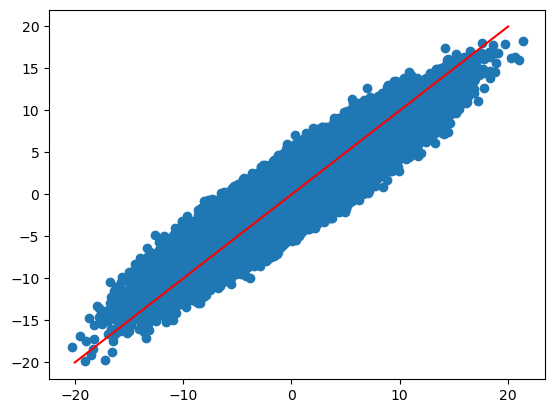

In [60]:
with torch.no_grad():
    dhat, uhat = gl.encoder(dat_true["x"], dat_true["y"])
    yhat = gl.decoder(dat_true["x"], dhat, uhat)

plt.scatter(dat_true["y"], yhat)
plt.plot([-20, 20], [-20, 20], color="red")

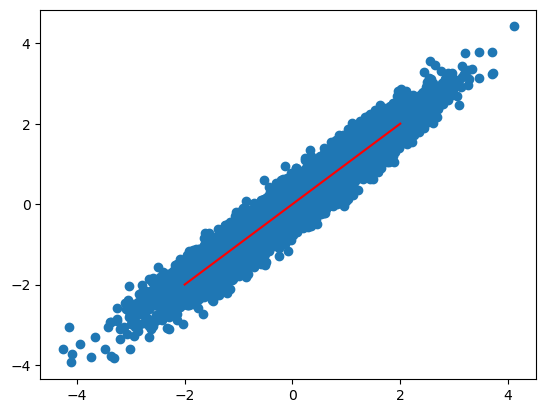

In [63]:
dhat = dhat*-1
plt.scatter(dhat, dat_true["d"])
plt.plot([-2, 2], [-2,2], color="red")

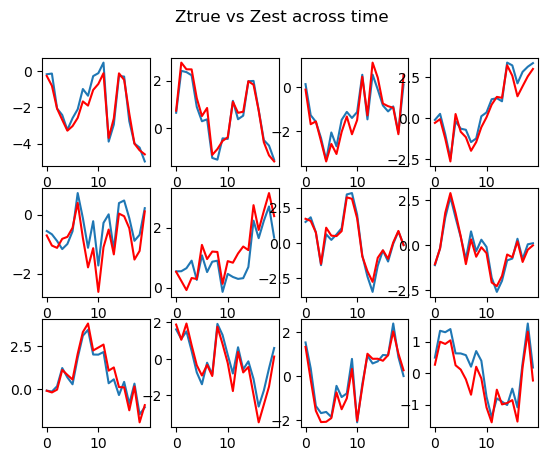

In [65]:
# print 12 randomly selected Z
index = np.random.choice(range(n), 12, replace=False)
fig, axs = plt.subplots(3, 4)

zhat= -gl.decoder.AR(dhat).detach()
z_true= gl_true.decoder.AR(dat_true["d"]).detach()
fig.suptitle("Ztrue vs Zest across time")
for i in range(12):
    axs[i//4, i%4].plot(zhat[index[i],:,0]*-1)
    axs[i//4, i%4].plot(z_true[index[i],:, 0], color="red")

In [51]:
par_true = gl_true.decoder.parameters().__next__().detach().squeeze()
par_est = gl.decoder.parameters().__next__() .detach().squeeze()

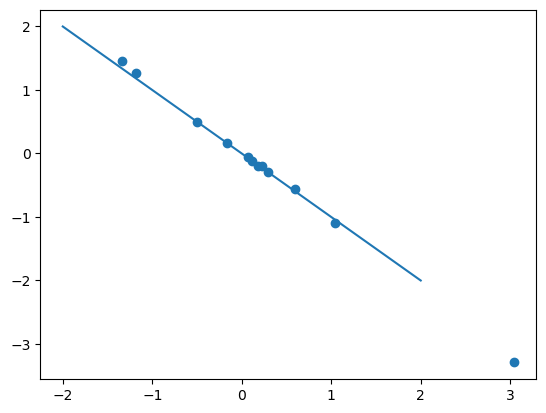

In [54]:
plt.scatter(par_true, par_est)
plt.plot([-2,2], [2, -2])

Parameter containing:
tensor([[-0.1917,  1.7052,  1.5688, -1.9336,  1.2903, -0.2464, -0.9208, -0.8981,
         -0.3629, -1.9462,  1.1807,  1.7579, -0.6408, -0.9203,  0.1704]],
       requires_grad=True)

In [18]:
rnn = nn.RNN(10, 20, 2)
input = torch.randn(5, 3, 10)
h0 = torch.randn(2, 3, 20)
output, hn = rnn(input, h0)

In [19]:
input

tensor([[[-0.4933,  1.5256, -1.0954,  0.9415,  0.0749,  0.5721,  0.5594,
          -1.1498,  0.2099,  0.4694],
         [-0.3344,  0.1942, -0.7034,  0.4629, -1.2898,  0.2803, -0.2243,
           1.3108,  2.6134,  0.6426],
         [ 0.1557,  1.5167, -0.6572, -1.2525, -1.5176, -0.1339, -0.8516,
           0.0916,  0.0129,  0.6163]],

        [[ 1.4279,  0.1257,  0.2034,  0.3920,  1.0154, -1.1235, -1.2475,
          -0.4898,  1.0222, -0.8360],
         [-0.6828, -2.2242, -0.4324, -1.1709, -1.9163, -0.1186,  0.6248,
           0.0899,  2.4953,  1.2641],
         [-2.0851, -0.6691, -1.7475, -1.5473, -0.7328,  1.6922, -1.8650,
           0.2673, -1.0303,  0.1084]],

        [[-0.0238,  1.6200, -0.6585,  1.4914, -2.6499, -0.2674,  0.6466,
           0.5169, -1.1068,  0.2170],
         [-1.3180, -0.8179,  0.8362,  0.6499,  0.4542,  1.7222,  1.1707,
          -1.1569,  0.5677,  0.0027],
         [-0.5776, -2.0234, -0.6848,  1.5876,  1.7223, -2.0019, -0.6659,
          -0.7057, -1.1529, -0.5410

### Details on tensor products calculations
We now show the details on the tensor products, for instance for computing `xb @ wx`. `xb` is of size `(n, T, q)` and `wx` is of size `(T, q, p)`. We want a result of size `(n, T, p)`. First we add a dimension for `xb`:

`xb.unsqueeze(2)` which yields a dimensions of `(n, T, 1, q)`

which we then multiply by `wz`:

`(n, T, 1, q) @ (1, q, p)` -> `(n, T, 1, p)`

where the first dimension of `wx` has been broadcasted.

Finally, we squeeze to obtain `(n, T, p)`.

### Details on the computation of the forward pass

The forward pass depends on $z_{it}$. According to the model, we have

$$z_{i1} \sim N(0,\sigma_z^2).$$

For identifiability reason, we have $z_{i1} = \delta_{i1}$ where $\delta_{i1}\sim N(0,1)$

and then

$$z_{it+1} = \phi z_{it} + \delta{it}$$

$$z_{i2} = \phi \delta_{i1} + \delta_{i1}$$

$$z_{i4} = \phi z_{i3} + \delta_{i3} \Rightarrow z_{i3} = \phi^2 \delta_{i1} + \phi \delta_{i2} + \delta_{i3}$$

$$z_{it+1} = \phi^{t-1}\delta_{i1} + ... + \phi \delta_{it-1} + \delta_{it}$$


So we do not need in-place computations in the forward pass. 
